In [2]:
import gym
import gym_2048


In [3]:
from tensorforce.agents import Agent
from tensorforce.environments import Environment

In [4]:
import numpy as np

In [8]:
import matplotlib.pyplot as plt

In [66]:
environment = Environment.create(
    environment='gym', level='2048-v0', max_episode_timesteps=1000)

agent = Agent.create(
    agent='double_dqn', 
    environment=environment, 
    batch_size=2,
    learning_rate=0.000001,
    discount = 0.99,
    l2_regularization=0.1,
    exploration=0.1,
    memory=10_000)

# Train for 100 episodes

rewards_episode =[]
max_tile_episode=[]
for episode in range(1000):
    states = environment.reset()
    terminal = False
    sum_rewards = 0.0
    num_updates = 0
    while not terminal:
        actions = agent.act(states=states)
        states, terminal, reward = environment.execute(actions=actions)
        agent.observe(terminal=terminal, reward=reward)
        #agent.update()
        sum_rewards += reward
    max_episode = np.amax(environment._environment.environment.Matrix)
    max_tile_episode.append(max_episode)
    rewards_episode.append(sum_rewards)
    #print('Episode {}: return={} max tile={}'.format(episode, sum_rewards, max_episode))


KeyboardInterrupt: 

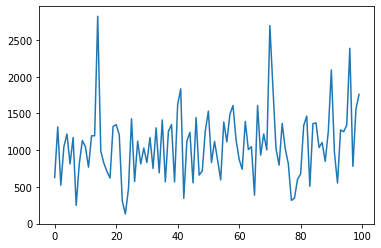

In [31]:
plt.plot(rewards_episode)

(array([ 9.,  0., 37.,  0., 50.,  0.,  0.,  0.,  0.,  4.]),
 array([ 16.,  40.,  64.,  88., 112., 136., 160., 184., 208., 232., 256.]),
 <BarContainer object of 10 artists>)

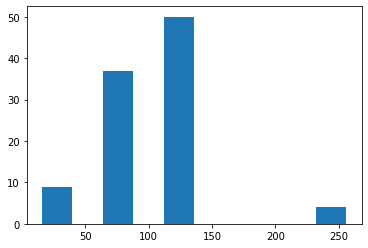

In [32]:
plt.hist(max_tile_episode)

In [38]:
from tensorforce.core.networks import AutoNetwork

In [50]:
from tensorforce.core.networks import LayeredNetwork

In [53]:
agent.get_architecture()

AttributeError: 'DoubleDQN' object has no attribute 'get_architecture'